# Defect Prediction on production lines by VALEO
## Challenge context
Valeo is a French global automotive supplier headquartered in France, listed on the Paris Stock Exchange (CAC-40 Index). It supplies a wide range of products to automakers and the aftermarket. The Group employs 113,600 people in 33 countries worldwide. It has 186 production plants, 59 R&D centers and 15 distribution platforms. Its strategy is focused on innovation and development in high-growth potential regions and emerging countries. Valeo ranked as France's leading patent filer from 2016 to 2018.
 
## Challenge goals
The goal of the challenge is to predict defect on starter motor production lines. During production samples assembly, different values (torques, angles ...) are measured on different mounting stations. At the end of the line, additional measures are performed on two test benches in order to isolate defects. As a result, samples are tagged ‘OK’, ‘KO’. We would like to design a model that could identify such defects before the test bench step.

## Data description
**ID** = PROC_TRACEINFO = it’s a unique code given to the product. Example : I-B-XA1207672-190701-00494.

XA1207672 is the reference.
190701 is the date: here 01st of July of year 2019.
00494 is the unique code given to the product, whatever it happens, the product will have this id number frozen forever.
This number is increased by 1 each time we process a new product, every 12s. So for example : I-B-XA1207672-190701-00495 is the next product.

**Inputs** : Input features are measures collected on different assembly stations with the sensors or devices connected to Programmable Logic Controllers which are storing all of them to keep the full quality traceability. (Examples : OP070_V_1_angle_value, OP120_Rodage_I_value, etc…).

**Output** : This is the result value of OP130 (test bench). Value 0 is assigned to OK samples (passed) and value 1 is assigned to KO samples (failed). This is the combined result of multiple electrical, acoustic and vibro-acoustic tests.

**The target** is to find the best prediction : Output = f (inputs). The dataset contains 34515 training samples and 8001 test samples.

***

# Model Building: Unsupervised Learning 

## Data Preparation

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
nb_path = os.path.abspath(".")
pd.set_option("max_rows", 10)
sns.set()

In [112]:
dataset = pd.read_csv(os.path.join(nb_path,"traininginputs.csv")).merge(pd.read_csv(os.path.join(nb_path,"trainingoutput.csv")), on="PROC_TRACEINFO")

In [34]:
target = "Binar OP130_Resultat_Global_v"
code = "PROC_TRACEINFO"
capuchon_measure = "OP100_Capuchon_insertion_mesure"
selected_measures = ['OP070_V_1_angle_value','OP090_SnapRingPeakForce_value', 'OP090_SnapRingFinalStroke_value','OP070_V_1_torque_value','OP090_SnapRingMidPointForce_val', 'OP070_V_2_torque_value']
features = list(dataset.drop([target, code], axis=1).columns)

In [35]:
normal_data = dataset[dataset[target]==0]
anomalous_data = dataset[dataset[target]==1]

In [36]:
print(normal_data.shape, anomalous_data.shape)

(34210, 15) (305, 15)


In [37]:
from sklearn.model_selection import train_test_split

In [38]:
trainset, testset = train_test_split(normal_data, test_size=0.1, random_state=0)

## Exploratoration : https://arxiv.org/pdf/1901.03407.pdf

We will try to determine the appropriate ML or DL model based on the data characteristics.

Deep anomaly detection (DAD) models can be broadly classified into three categories based on the extent of availability of labels. (1) Supervised deep anomaly detection. (2) Semi-supervised deep anomaly detection. (3) Unsupervised
deep anomaly detection

* Semi-supervised DAD techniques are more widely adopted, these techniques leverage existing labels of single (normally positive class) to separate outliers. One common way of using deep autoencoders in anomaly detection is to train them in a semi-supervised way on data samples with no anomalies. With sufficient training samples, of normal class autoencoders would produce low reconstruction errors for normal instances, over unusual events

* Supervised deep anomaly detection involves training a deep supervised binary or multi-class classifier, using labels of both normal and anomalous data instances. these methods are not as popular as semi-supervised or unsupervised methods, owing to the lack of availability of labeled training samples

* determine the type of anomaly

    * point: Point anomalies often represent an irregularity or deviation that happens randomly and may have no particular interpretation

    * contextual: A contextual anomaly is also known as the conditional anomaly is a data instance that could be considered as anomalous in some specific context. Contextual anomaly is identified by considering both contextual and behavioural features. The contextual features, normally used are time and space.

    * collective: Anomalous collections of individual data points are known as collective or group anomalies, wherein each of the individual points in isolation appears as normal data instances while observed in a group exhibit unusual characteristics.

* Visualiser les anomalies sur l'echelle temporelle: determine if ~~sequential~~ or non-sequential data

Unsupervised anomaly detection techniques using autoencoders measure the magnitude of the residual vector (i,e reconstruction error) for obtaining anomaly scores, later on, the reconstruction errors are either ranked or thresholded by domain experts to label data instances.



### Anomaly Type

In [19]:
def code_to_datetime(df):
    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        df[['Date', 'Time']] = df.loc[:, code].str.rsplit("-", 2, expand=True).drop([0], axis=1)
        df['Date'] = pd.to_datetime(df.loc[:,'Date'], format="%y%m%d")
        df.sort_values(['Date', 'Time'], inplace=True)

        df['Time'] = (df['Time'].astype(int)*12).astype('timedelta64[s]')
        maxseconds = df['Time'].max()
        df["Datetime"] = np.datetime64()
        i=0
        while i < len(df):
            df["Datetime"].iloc[i] = df["Date"].iloc[i]
            i+=1
            while (i < len(df)) and (df["Date"].iloc[i-1] == df["Date"].iloc[i]) :
                df["Datetime"].iloc[i] = df["Datetime"].iloc[i-1] + np.mod((df['Time'].iloc[i] + maxseconds - df['Time'].iloc[i-1]), maxseconds)
                i+=1
        df = df.drop(['Time', code], axis=1)
    
    return df

In [39]:
trainset = code_to_datetime(trainset).set_index("Datetime", inplace=True)
an_trainset = code_to_datetime(anomalous_data).set_index("Datetime", inplace=True)
all_trainset = code_to_datetime(dataset).set_index("Datetime", inplace=True)

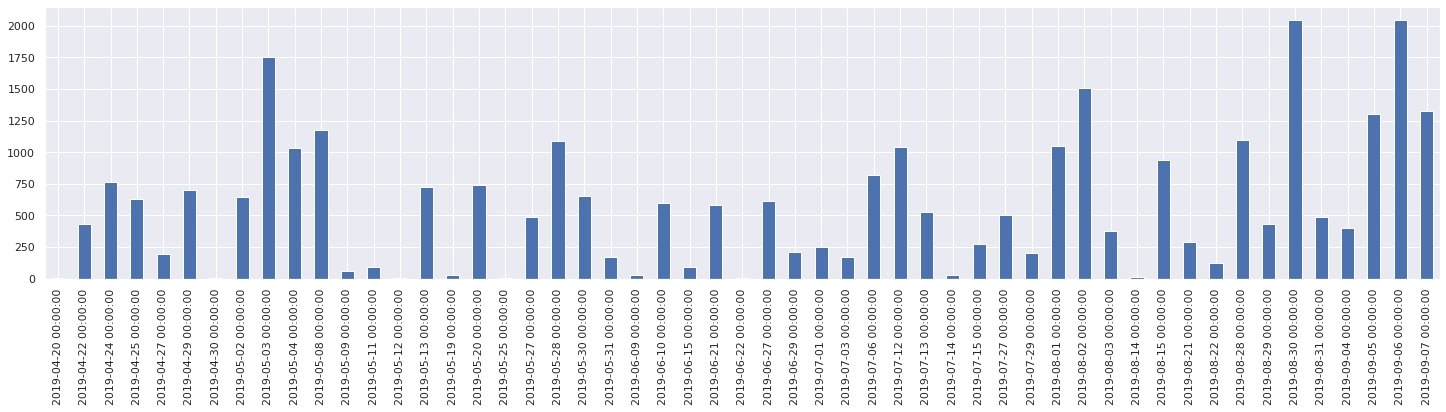

In [27]:
(trainset['Date'].value_counts().sort_index()).plot(kind='bar', figsize=(25,5))

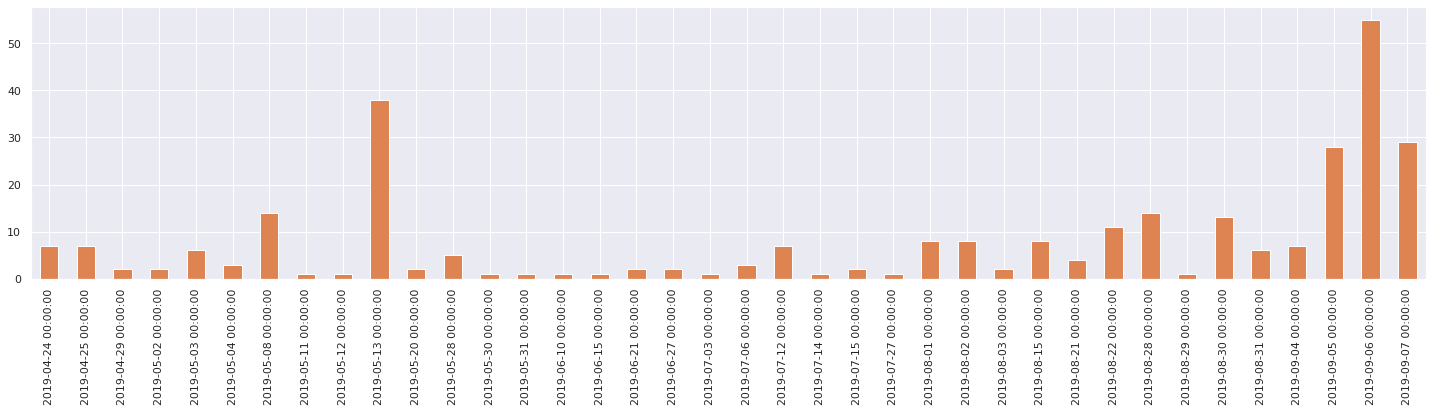

In [28]:
(an_trainset['Date'].value_counts().sort_index()).plot(kind='bar', color=sns.color_palette()[1], figsize=(25,5))

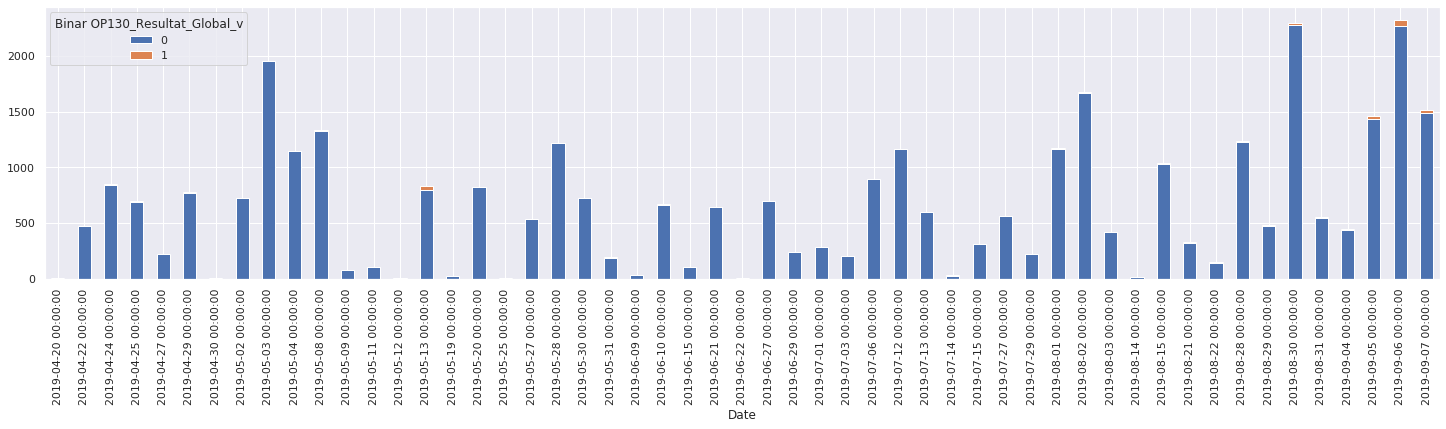

In [31]:
all_trainset.pivot_table(index='Date', columns=target, values=features[0], aggfunc=lambda x: x.count()).plot(kind='bar', figsize=(25,5), stacked=True)

In [120]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

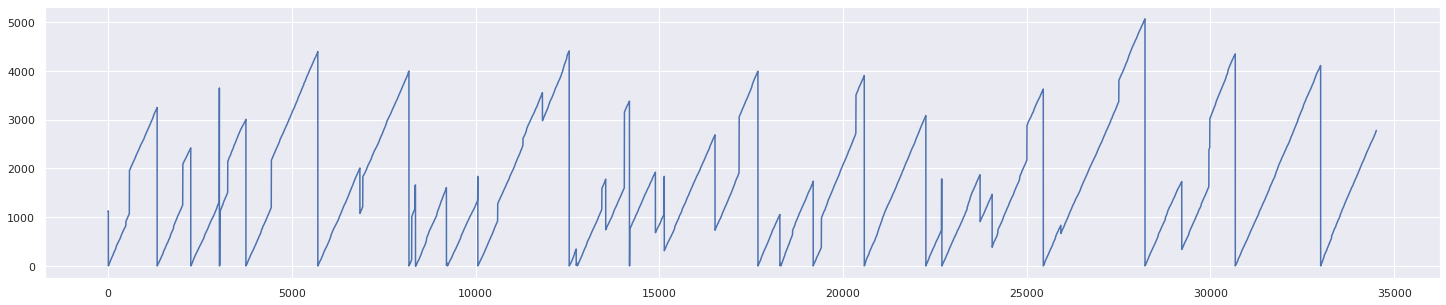

In [157]:
# plt.figure(figsize=(25,5))
# plt.plot(dataset['Time'].astype(int).values)

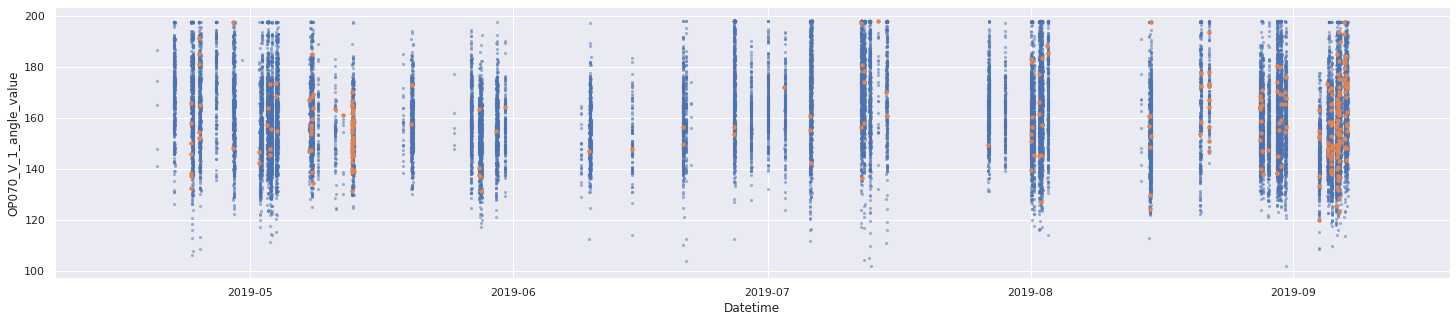

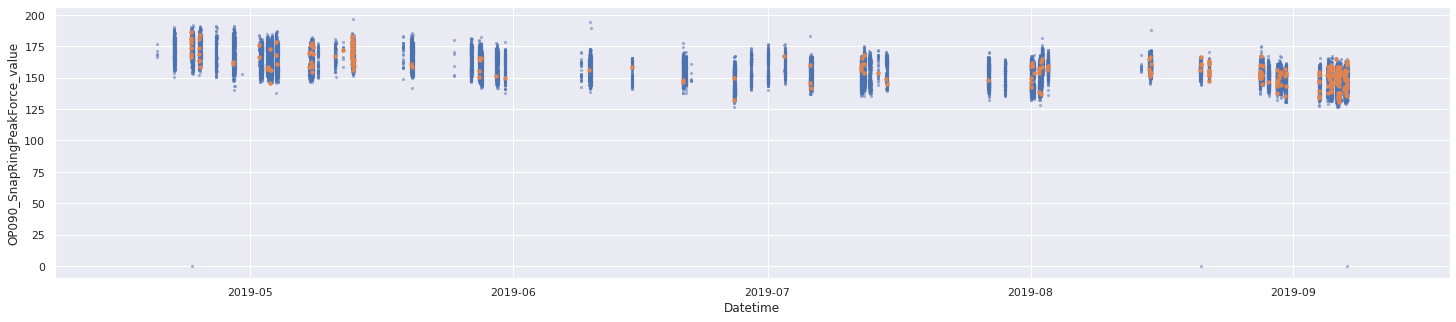

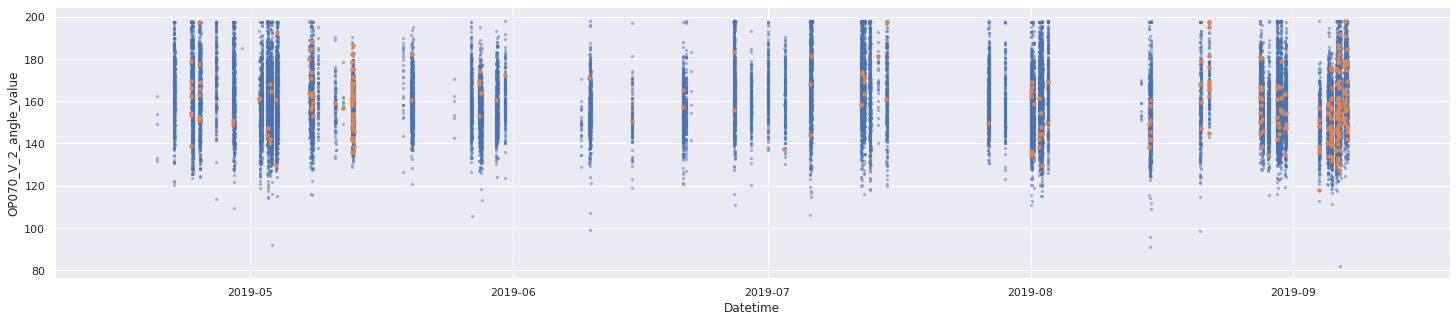

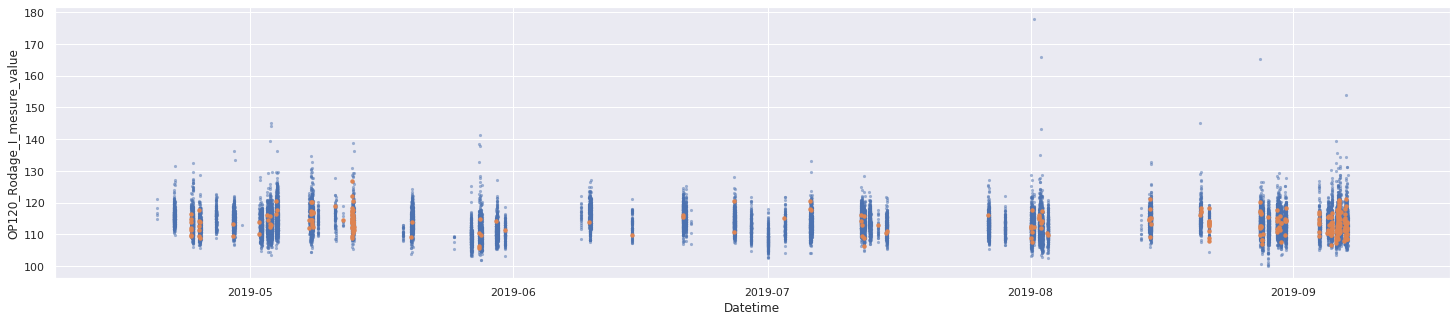

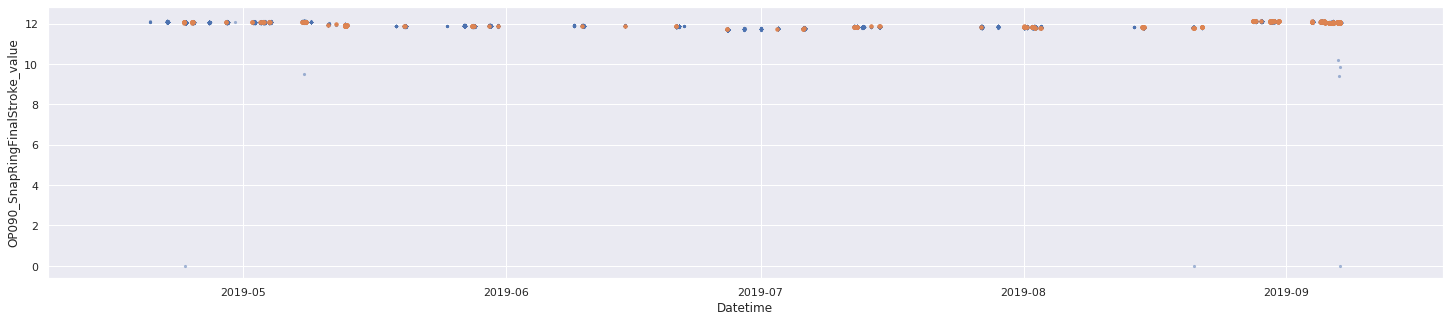

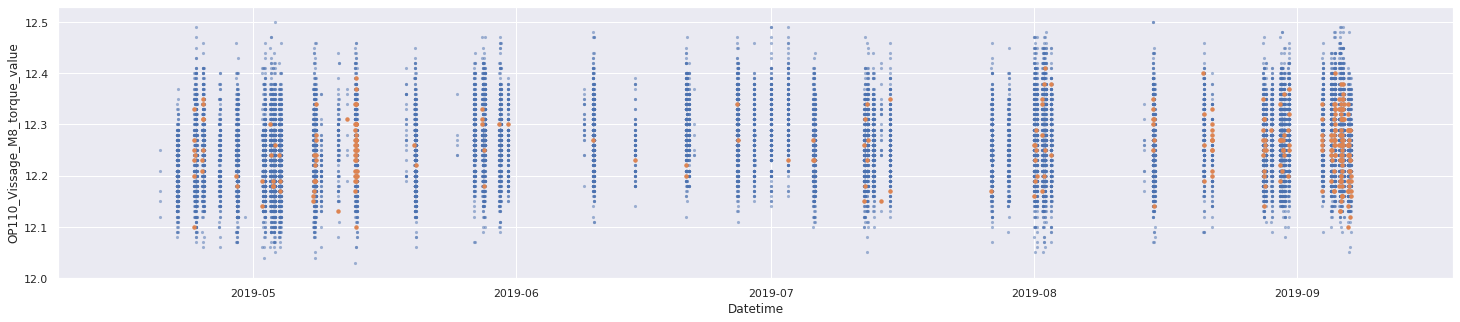

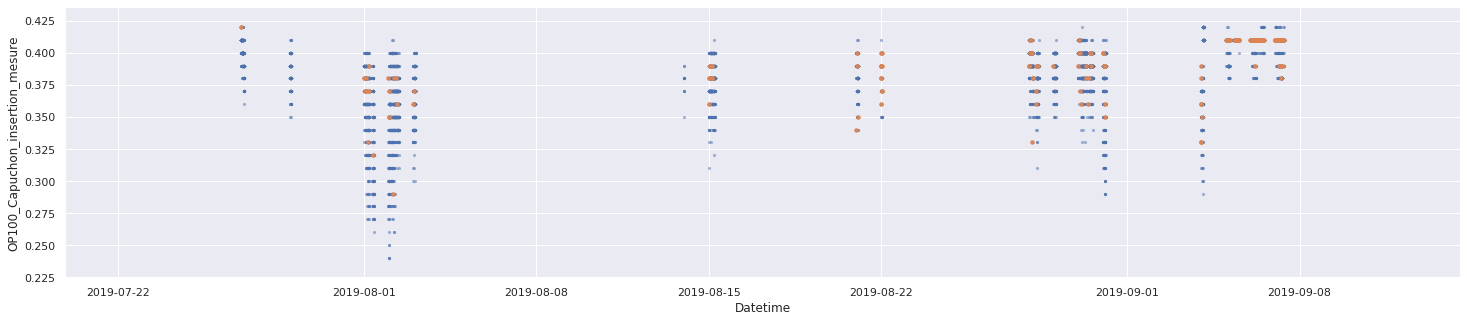

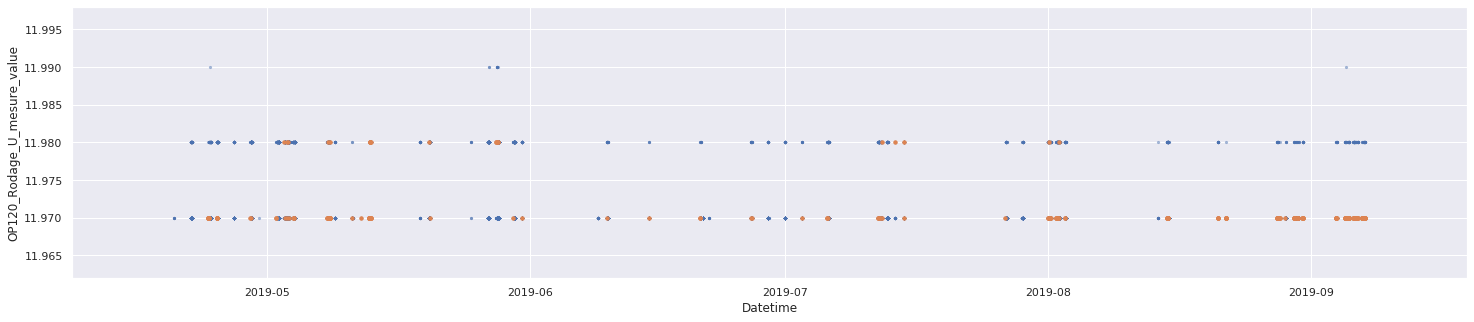

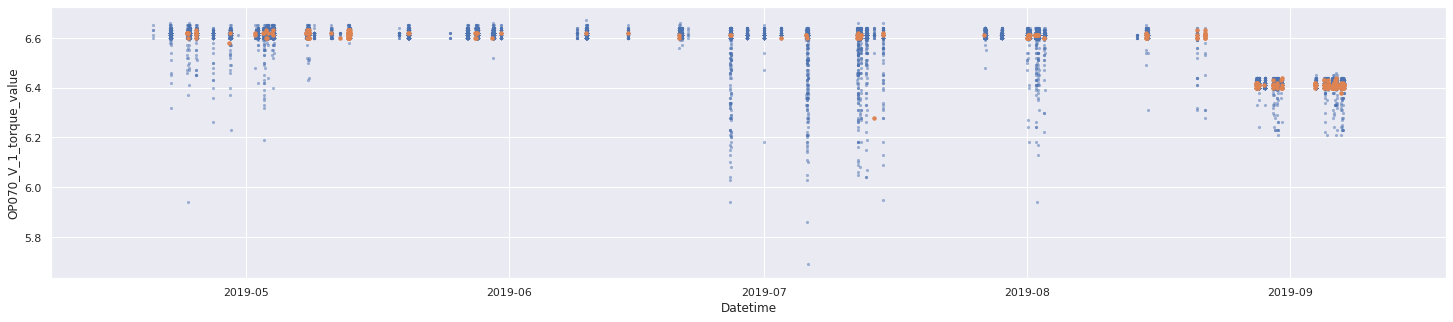

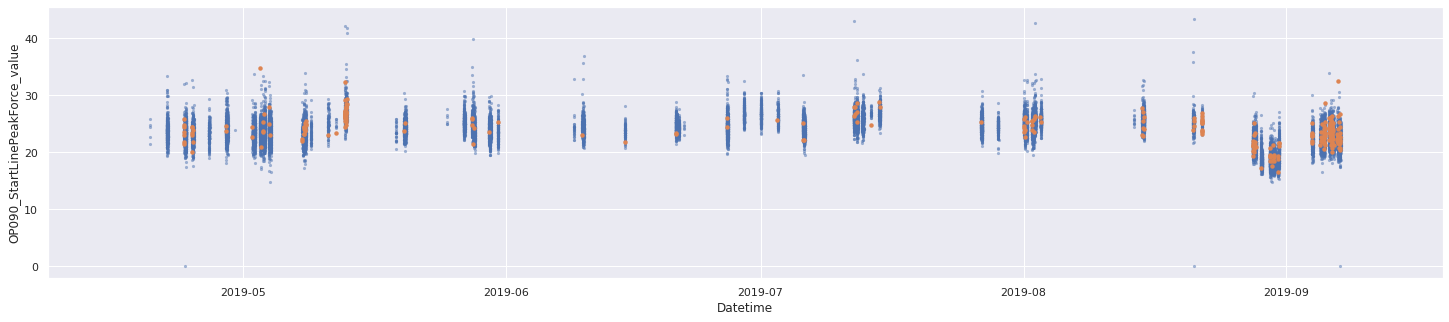

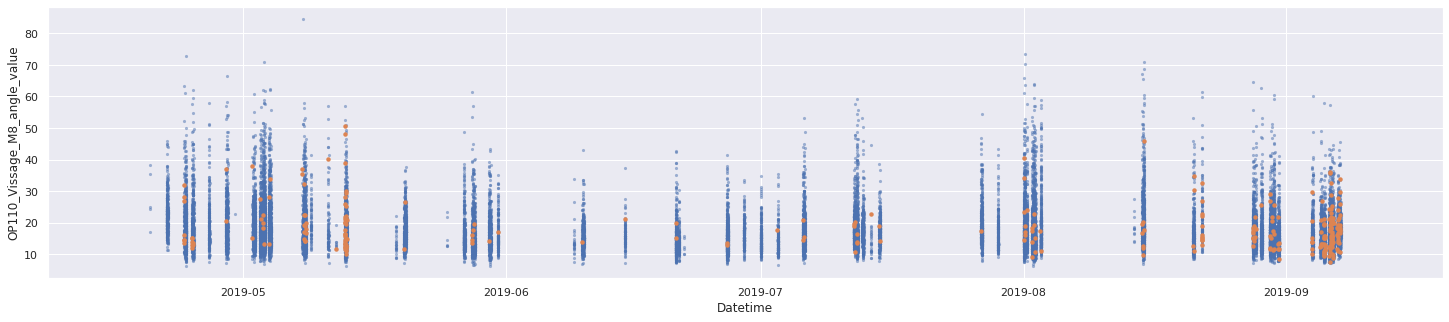

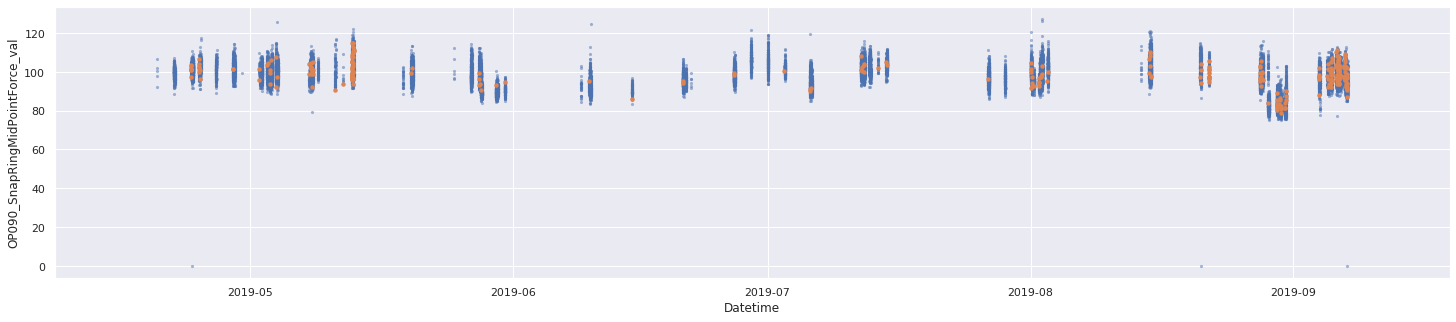

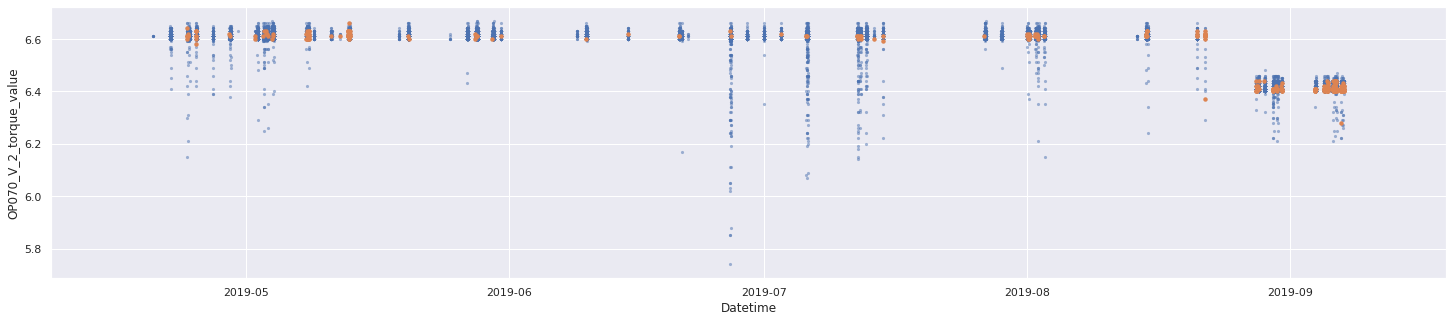

In [81]:
for feat in features:
    plt.figure(figsize=(25,5))
    sns.scatterplot(x=trainset.index, y= feat, data=trainset, s=10, alpha=0.5, linewidth=0) #s =size
    sns.scatterplot(x=an_trainset.index, y= feat, data=an_trainset, s=20, linewidth=0) 

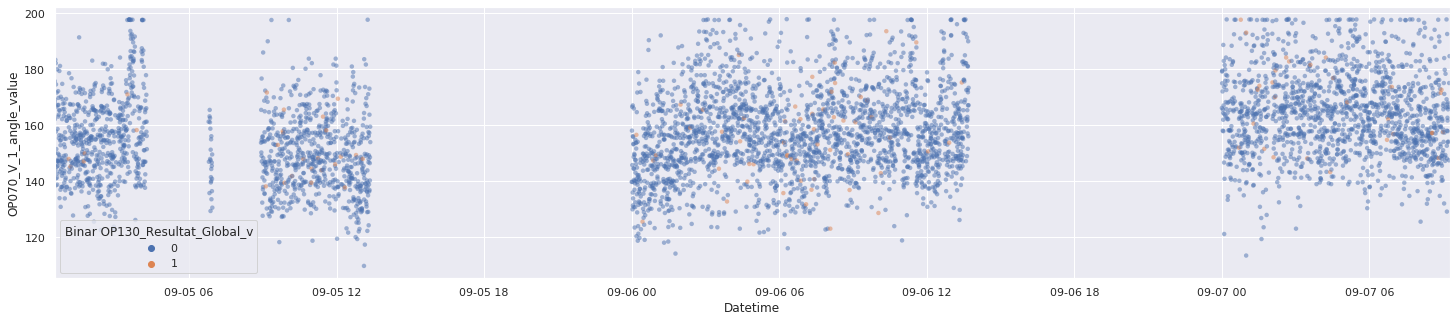

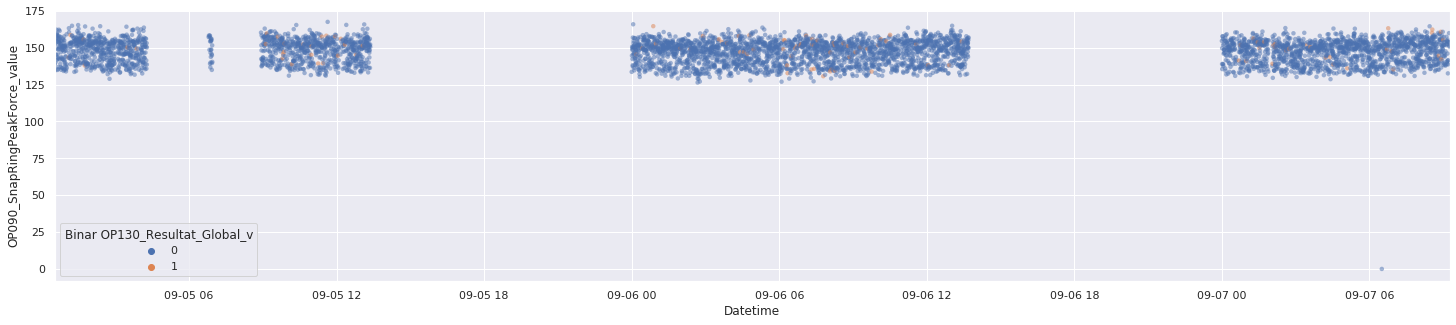

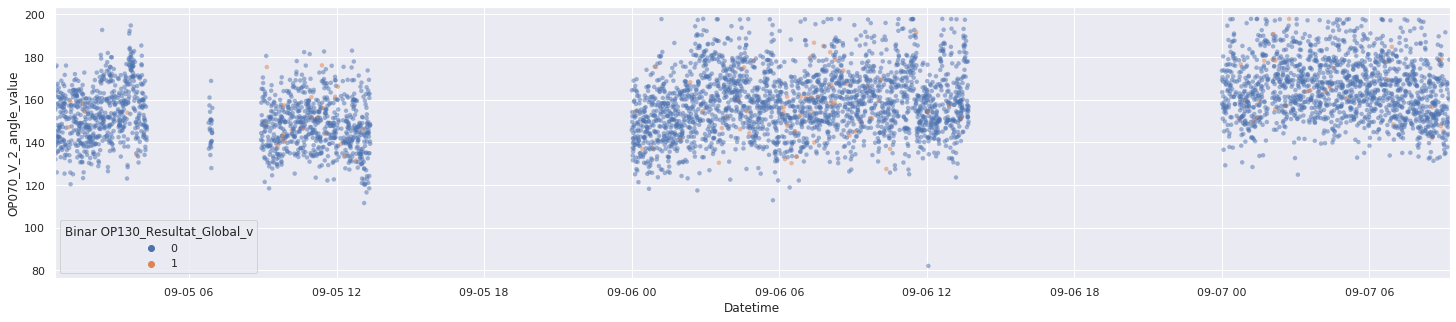

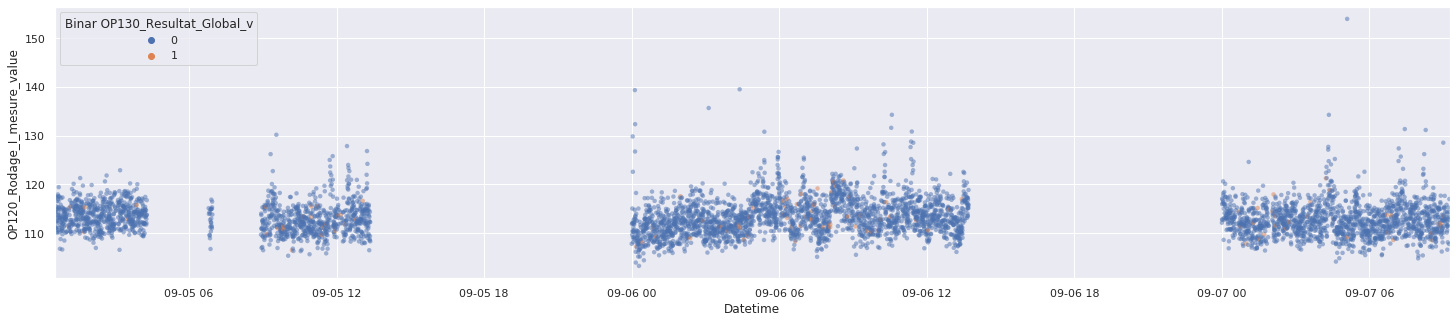

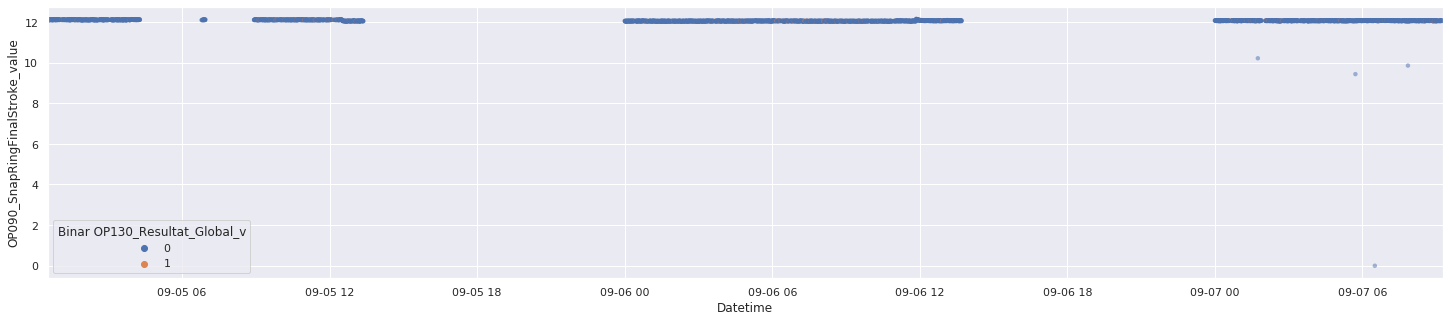

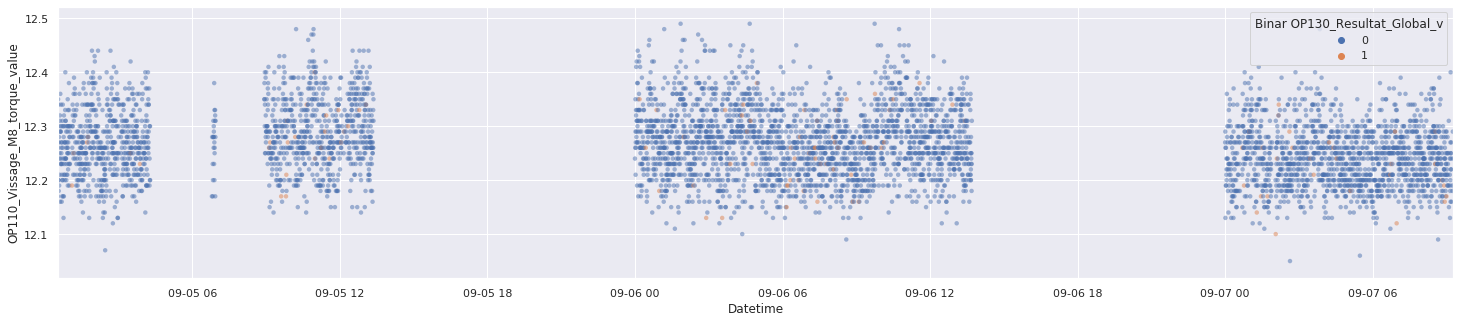

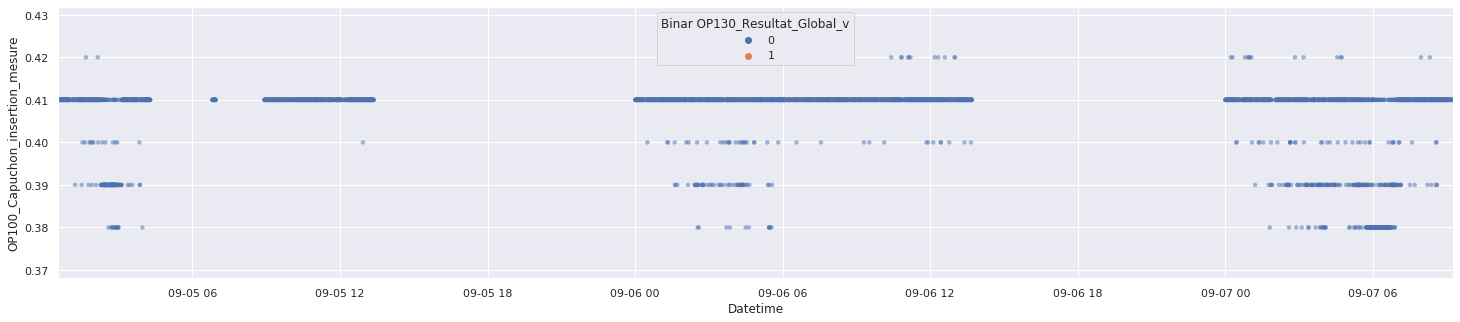

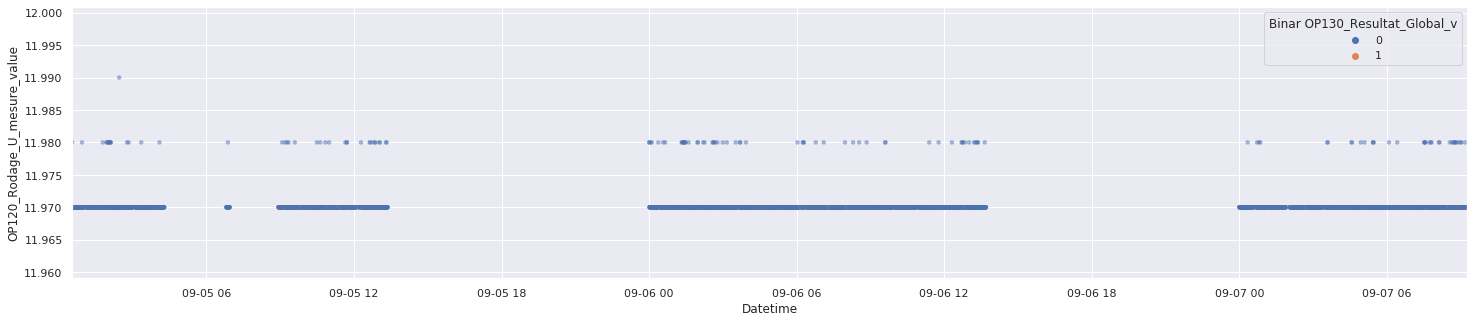

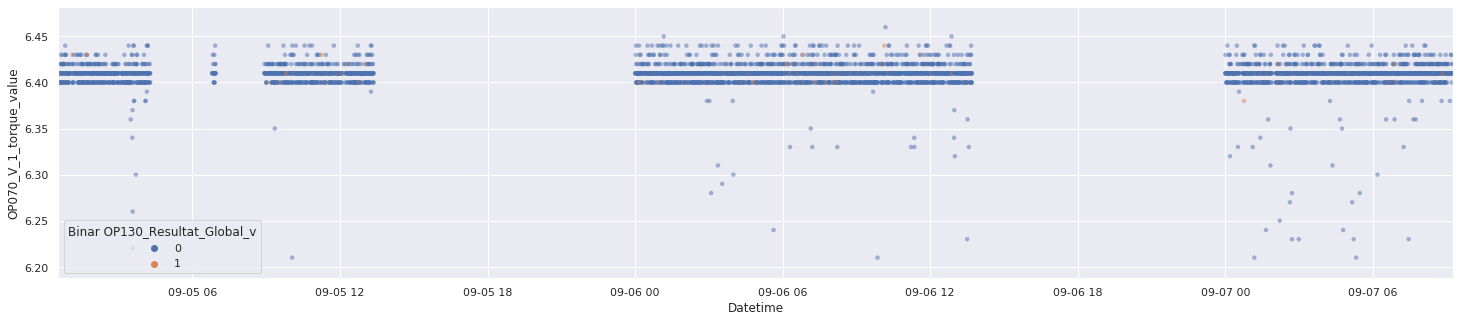

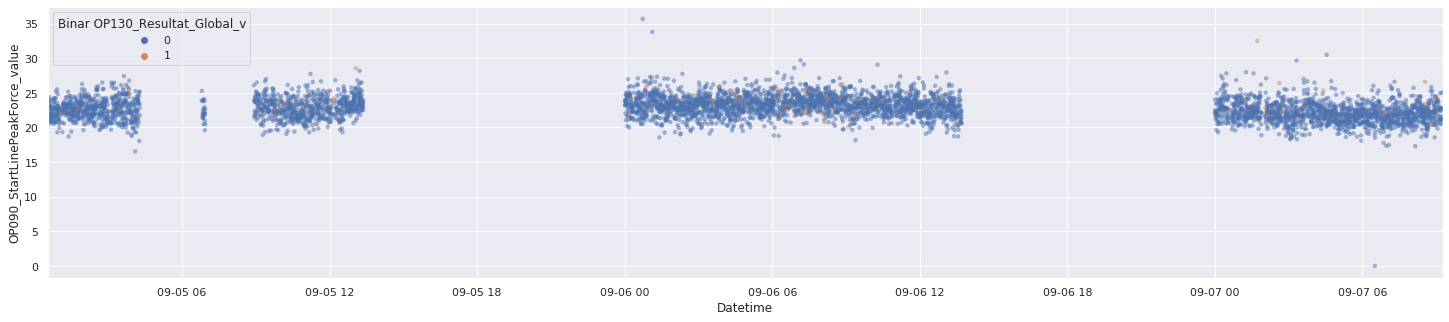

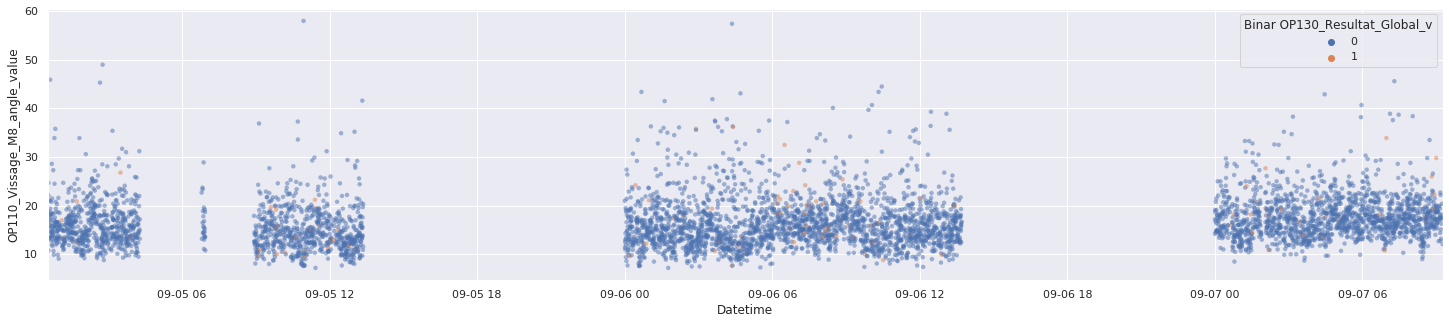

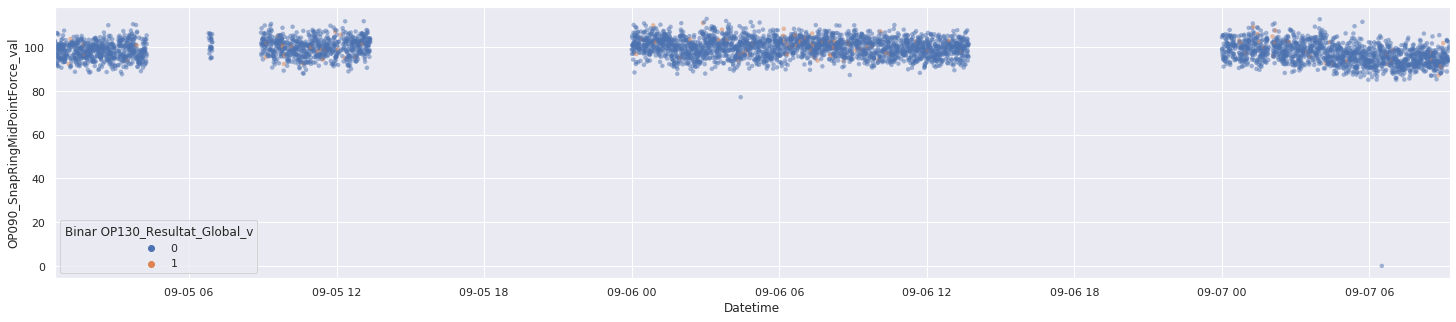

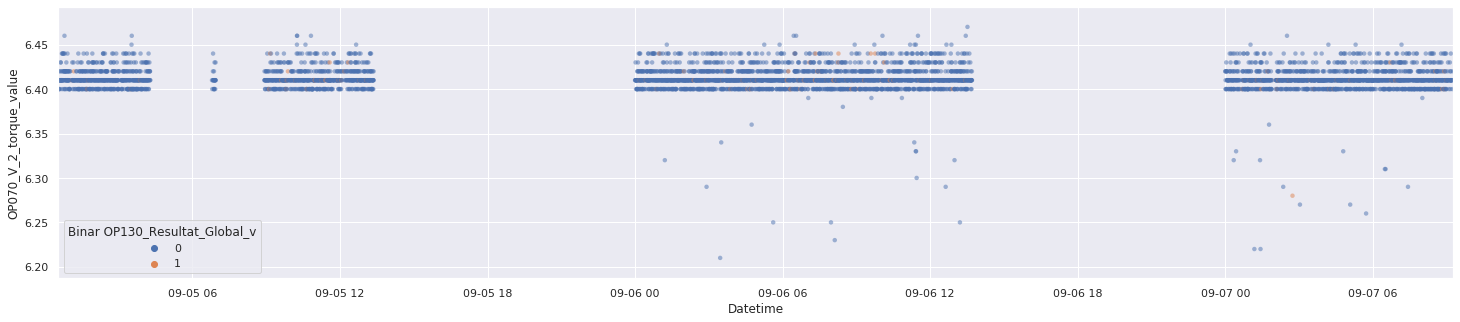

In [107]:
#zoom in the last three days
for feat in features:
    plt.figure(figsize=(25,5))
    sns.scatterplot(x=all_trainset.iloc[-5200:-1].index, y=feat, hue=target, data=all_trainset.iloc[-5200:-1], s=20, alpha=0.5, linewidth=0 ) #s =size
    plt.xlim(all_trainset.iloc[-5200].name, all_trainset.iloc[-1].name)

Except for the "Rodage" features, we cannot distinguish properly the anomalous data from the normal data.

We can also drop the Datetime column as we don't se any sequential relations.

## Data Preparation

In [4]:
dataset = pd.read_csv(os.path.join(nb_path,"traininginputs.csv")).merge(pd.read_csv(os.path.join(nb_path,"trainingoutput.csv")), on="PROC_TRACEINFO")

In [17]:
target = "Binar OP130_Resultat_Global_v"
























































code = "PROC_TRACEINFO"
capuchon_measure = "OP100_Capuchon_insertion_mesure" # the only feature with 50% nan values
selected_measures = ['OP070_V_1_angle_value','OP090_SnapRingPeakForce_value', 'OP090_SnapRingFinalStroke_value','OP070_V_1_torque_value','OP090_SnapRingMidPointForce_val', 'OP070_V_2_torque_value']
features = list(dataset.drop([target, code], axis=1).columns)

In [18]:
# datetime and target columns are not needed to train the autoencoder
# normal_data = dataset[dataset[target]==0].drop([code, capuchon_measure, target], axis=1)
# anomalous_data = dataset[dataset[target]==1].drop([code, capuchon_measure, target], axis=1)
normal_data = dataset[dataset[target]==0][selected_measures]
anomalous_data = dataset[dataset[target]==1][selected_measures]

## Basic Autoencoder

In [44]:
# Import some libraries

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

In [45]:
# Define data loading step

batch_size = 1024

trainset, testset = train_test_split(normal_data, test_size=0.1, random_state=0)

# "Standardize" the data
sc = RobustScaler().fit(trainset)

trainset = torch.tensor(sc.transform(trainset),  dtype=torch.float32)
testset = torch.tensor(sc.transform(testset),  dtype=torch.float32)
an_testset  = torch.tensor(sc.transform(anomalous_data),  dtype=torch.float32)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)
an_loader = DataLoader(an_testset, batch_size=batch_size, shuffle=True)

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
# Define model architecture and reconstruction loss

n = trainset.shape[1]
d = 2

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, n),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

In [47]:
n = trainset.shape[1]
d1 = 4
d2 = 2
d3 = 1

class Autoencoder_Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n, d1),
            nn.ReLU(True),
            nn.Linear(d1, d2),
            nn.ReLU(True), 
            nn.Linear(d2, d3))
        self.decoder = nn.Sequential(
            nn.Linear(d3, d2),
            nn.ReLU(True),
            nn.Linear(d2, d1),
            nn.ReLU(True),
            nn.Linear(d1, n),
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = Autoencoder_Deep().to(device)
criterion = nn.MSELoss()

In [48]:
# Configure the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

# Configure the scheduler

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)


In [49]:
# Train autoencoder (AE)

num_epochs = 1000

for epoch in range(num_epochs):
    for data in train_loader:
        data = data.to(device)
        # ===================forward=====================
        output = model(data)  
        loss = criterion(output, data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    step_lr_scheduler.step()
    # ===================log========================
    if (epoch % 50) == 0 :
        print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}') 

epoch [1/1000], loss:0.4157
epoch [11/1000], loss:0.2802
epoch [21/1000], loss:0.2694
epoch [31/1000], loss:0.2547
epoch [41/1000], loss:0.2045
epoch [51/1000], loss:0.2102
epoch [61/1000], loss:0.2326
epoch [71/1000], loss:0.2731
epoch [81/1000], loss:0.2278
epoch [91/1000], loss:0.2136
epoch [101/1000], loss:0.2316
epoch [111/1000], loss:0.1848
epoch [121/1000], loss:0.1811
epoch [131/1000], loss:0.1959
epoch [141/1000], loss:0.2870
epoch [151/1000], loss:0.1998
epoch [161/1000], loss:0.2027
epoch [171/1000], loss:0.1704
epoch [181/1000], loss:0.2117
epoch [191/1000], loss:0.2163
epoch [201/1000], loss:0.1993
epoch [211/1000], loss:0.2798
epoch [221/1000], loss:0.2297
epoch [231/1000], loss:0.1829
epoch [241/1000], loss:0.1968
epoch [251/1000], loss:0.1777
epoch [261/1000], loss:0.2150
epoch [271/1000], loss:0.2179
epoch [281/1000], loss:0.2260
epoch [291/1000], loss:0.1969
epoch [301/1000], loss:0.1744
epoch [311/1000], loss:0.1512
epoch [321/1000], loss:0.2270
epoch [331/1000], los

In [50]:
# Test the model
with torch.no_grad():
    normal_result = []
    anomalous_result = []
    for data in test_loader:
        data = data.to(device)
        output = model(data)
        normal_result.append(criterion(output, data))
        
    for data in an_loader:
        data = data.to(device)
        output = model(data)
        anomalous_result.append(criterion(output, data))

In [51]:
print(normal_result) 
print(anomalous_result)

[tensor(0.1931, device='cuda:0'), tensor(0.1980, device='cuda:0'), tensor(0.2005, device='cuda:0'), tensor(0.1827, device='cuda:0')]
[tensor(0.1818, device='cuda:0')]


## State of the art technique: One-class Neural Network

In [ ]:
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


num_epochs = 100
batch_size = 128
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = MNIST('./data', transform=img_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), nn.Linear(64, 12), nn.ReLU(True), nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.data[0]))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './mlp_img/image_{}.png'.format(epoch))

torch.save(model.state_dict(), './sim_autoencoder.pth')

In [38]:
#device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [48]:
#hyperparameter
input_size = len(features) # =13
hidden_size = 2
output_size = len(features)
num_epochs = 10
batch_size = 1024
learning_rate = 1e-3

In [57]:
# dataset
dataset = pd.read_csv(os.path.join(nb_path,"traininginputs.csv")).merge(pd.read_csv(os.path.join(nb_path,"trainingoutput.csv")), on="PROC_TRACEINFO")
normal_data = dataset[dataset[target]==0]
anomalous_data = dataset[dataset[target]==1]

In [60]:
pd.read_csv(os.path.join(nb_path,"trainingoutput.csv"))

,PROC_TRACEINFO,Binar OP130_Resultat_Global_v
0,I-B-XA1207672-190429-00688,0
1,I-B-XA1207672-190828-00973,0
2,I-B-XA1207672-190712-03462,0
3,I-B-XA1207672-190803-00051,0
4,I-B-XA1207672-190508-03248,0
...,...,...
34510,I-B-XA1207672-190520-00031,0
34511,I-B-XA1207672-190906-00270,0
34512,I-B-XA1207672-190429-00930,0
34513,I-B-XA1207672-190424-02120,0


## submit

In [6]:
submission_dataset = pd.read_csv(os.path.join(nb_path,"testinputs.csv")) 